In [1]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd

import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist

%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
def saveFig( ax, outdir, name,xr, xl, scale='linear'):
    ax.set_yscale(scale)
    ax.set_ylim(0.001,10)
    ax.set_xlim(xr,xl)
    ax.figure.savefig(os.path.join(outdir, "{}.png".format(name)))


In [39]:
#define processor

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 500, 0, 2000)
        mass_axis            = hist.Bin("mass", r"$mass$ (GeV)", 500, 0, 1000)
        eta_axis             = hist.Bin("eta", r"$\eta$", 80, -4, 4)
        phi_axis             = hist.Bin("phi", r"$\phi$", 70, 0, 7)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 20, -0.5, 19.5)
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "MET_pt":               hist.Hist("Counts", dataset_axis, pt_axis),
            "LeadJet_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "LeadBJet_pt" :         hist.Hist("Counts", dataset_axis, pt_axis),
            "nB" :                  hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "nJet" :                hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "HT":                   hist.Hist("Counts", dataset_axis, pt_axis),
            "Mbb":                  hist.Hist("Counts", dataset_axis, mass_axis),
          #  "MT2_WH":               hist.Hist("Counts", dataset_axis, mass_axis),
          #  "MT2_bbjj":             hist.Hist("Counts", dataset_axis, mass_axis),
           # "MT2_bjjb":             hist.Hist("Counts", dataset_axis, mass_axis),
            "MCT_bb":               hist.Hist("Counts", dataset_axis, mass_axis),
            "MCT_jj":               hist.Hist("Counts", dataset_axis, mass_axis),
            "Mjj":                  hist.Hist("Counts", dataset_axis, mass_axis),
            "mindphijMET":          hist.Hist("Counts", dataset_axis, phi_axis),
            "bb_pt":                hist.Hist("Counts", dataset_axis, pt_axis),
            "dphibbMET":            hist.Hist("Counts", dataset_axis, phi_axis),
            "dphibbjj":             hist.Hist("Counts", dataset_axis, phi_axis),
            "nHtag":                hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "H_pt":                 hist.Hist("Counts", dataset_axis, pt_axis),
            "dphiWH":               hist.Hist("Counts", dataset_axis, phi_axis),
            "WHptMET":              hist.Hist("Counts", dataset_axis, multiplicity_axis)
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        
        #PRESELECTION
        met_ps = (df['MET_pt']>250)
        njet_ps = (df['nJet'] == 4)
        bjet_ps = (df['nGoodBTag'] == 2)
        tauveto_ps = (df['nVetoTau'] == 0)
        isotrackveto_ps = (df['nVetoIsoTrack'] == 0)
        mbbup_ps = (df['bb_mass'].min() > 90 )
        mbblo_ps = (df['bb_mass'].max() < 150)
        
        presel = met_ps & njet_ps & bjet_ps & tauveto_ps & isotrackveto_ps & mbbup_ps & mbblo_ps
        
        #DEFINE VARIABLES 
        
            #jets
        jets = awkward.JaggedArray.zip(pt=df['Jet_pt'], eta=df['Jet_eta'], phi=df['Jet_phi'], btag=df['Jet_btagDeepB'], jetid=df['Jet_jetId'], mass=df['Jet_mass'], n=df['nJet'])
        goodjets = jets[(jets['pt']>30) & (abs(jets['eta'])<2.4) & (jets['jetid']>0) ]
        bjets = jets[(jets['pt']>30) & (abs(jets['eta'])<2.4) & (jets['jetid']>0) & (jets['btag']>0.4184) ]
        fatjets = awkward.JaggedArray.zip(pt=df['FatJet_pt'], eta=df['FatJet_eta'], phi=df['FatJet_phi'], mass=df['FatJet_mass'], softdrop=df["FatJet_msoftdrop"], btag=df['FatJet_btagDeepB'], n=df['nFatJet'],fromH = df['FatJet_deepTagMD_HbbvsQCD'], fromW = df['FatJet_deepTagMD_WvsQCD'], fatjetid=df['FatJet_jetId'])
        goodfatjets = fatjets[(fatjets['pt'] > 200) & (fatjets['fatjetid']>0)]     

    
        wght = df['weight'][0]
        
        #FILL OUTPUTS
        output['MET_pt'].fill(dataset=dataset, pt=df["MET_pt"][presel].flatten(),
                              weight=wght)
        output['Mbb'].fill(dataset=dataset, mass=df["bb_mass"][presel].flatten(),
                              weight=wght)
        output['Mjj'].fill(dataset=dataset, mass=df["jj_mass"][presel].flatten(),
                              weight=wght)
        output['MCT_bb'].fill(dataset=dataset, mass=df["bb_mct"][presel].flatten(),
                              weight=wght)
        output['MCT_jj'].fill(dataset=dataset, mass=df["jj_mct"][presel].flatten(),
                              weight=wght)
        output['bb_pt'].fill(dataset=dataset, pt=df["bb_pt"][presel].flatten(),
                              weight=wght)
        
        output['HT'].fill(dataset=dataset,pt=goodjets['pt'][presel].sum().flatten(),
                              weight=wght)
        output['nB'].fill(dataset=dataset, multiplicity=bjets[presel].counts,
                              weight=wght)
        output['nJet'].fill(dataset=dataset, multiplicity=jets[presel].counts,
                              weight=wght)
        output['nHtag'].fill(dataset=dataset, multiplicity=df["nFatJetfromH"][presel],
                              weight=wght)
        output['H_pt'].fill(dataset=dataset, pt=df["FatJetfromH_pt"][presel].flatten(),
                              weight=wght)
        output['WHptMET'].fill(dataset=dataset, multiplicity=df['WHptMET'].flatten(),
                              weight=wght)
        output['LeadJet_pt'].fill(dataset=dataset, pt=goodjets['pt'][presel].max().flatten(),
                              weight=wght)
        output['LeadBJet_pt'].fill(dataset=dataset, pt=bjets['pt'][presel].max().flatten(),
                              weight=wght)
        output['mindphijMET'].fill(dataset=dataset,phi=df["mindphijmet"][presel].flatten(),
                              weight=wght)
        
        output['dphibbMET'].fill(dataset=dataset, phi=df["Dphibbmet"][presel].flatten(),
                                weight=wght)
        output['dphibbjj'].fill(dataset=dataset, phi=df["Dphibbjj"][presel].flatten(),
                                weight=wght)
        output['dphiWH'].fill(dataset=dataset, phi=df["DphiWH"][presel].flatten(),
                                weight=wght)
        
        
        return output

    
    def postprocess(self, accumulator):
        return accumulator
        

In [40]:
histograms = ["MET_pt",  "HT" ,  "nB", "nJet", "nHtag","H_pt", "WHptMET", "Mbb", "LeadJet_pt",
             "LeadBJet_pt", "MCT_bb", "MCT_jj", "mindphijMET", "bb_pt","dphibbMET",
              "dphibbjj", "dphiWH"]

fileset = {'mC750_mL1': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/WH_had_750_1__nanoAOD/merged/WH_had_750_1__nanoAOD_1.root'],
            'W+Jets': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                         ],
                'QCD':['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                    ],
            'TTJets':['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                      '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                      '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                      '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                      '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                      '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv66/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                   ]
          }

output = processor.run_uproot_job(fileset,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
     
outdir = "/home/users/mbryson/public_html/dump/WH/"


MET_pt
HT
nB
nJet
nHtag
H_pt
WHptMET


/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/mplhep/plot.py:226: RuntimeWarning: divide by zero encountered in true_divide
  binnorms /= np.outer(np.diff(bins), per_hist_norm).T
/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/mplhep/plot.py:237: RuntimeWarning: invalid value encountered in multiply
  h *= density_arr
/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/mplhep/plot.py:242: RuntimeWarning: invalid value encountered in multiply
  _yerr[i] = _yerr[i] * density_arr[i]


Mbb
LeadJet_pt
LeadBJet_pt
MCT_bb
MCT_jj
mindphijMET
bb_pt
dphibbMET
dphibbjj
dphiWH


/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/mplhep/plot.py:226: RuntimeWarning: divide by zero encountered in true_divide
  binnorms /= np.outer(np.diff(bins), per_hist_norm).T
/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/mplhep/plot.py:237: RuntimeWarning: invalid value encountered in multiply
  h *= density_arr
/home/users/mbryson/miniconda3/envs/analysisenv/lib/python3.8/site-packages/mplhep/plot.py:242: RuntimeWarning: invalid value encountered in multiply
  _yerr[i] = _yerr[i] * density_arr[i]


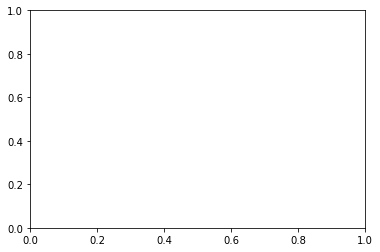

In [42]:
for name in histograms:
        print (name)
        histogram = output[name]
        #rebinning
        if name == 'MET_pt':
            new_met_bins = hist.Bin('pt', r'$E_T^{miss} \ (GeV)$', 20, 200, 1000)
            histogram = histogram.rebin('pt', new_met_bins)
            xr = 200
            xl = 800
        if name == 'HT':
            new_ht_bins = hist.Bin('pt', r'$H_T \ (GeV)$', 20, 0, 2000)
            histogram = histogram.rebin('pt', new_ht_bins)
            xr = 200
            xl = 2000
        if name == 'LeadJet_pt':
            new_ljpt_bins = hist.Bin('pt', r'$Lead \ Jet \ p_T  \ (GeV)$', 20, 200, 1000)
            histogram = histogram.rebin('pt', new_ljpt_bins)
            xr = 250
            xl = 1000
        if name == 'LeadBJet_pt':
            new_lbjpt_bins = hist.Bin('pt', r'$Lead \ BJet \ p_T  \ (GeV)$', 20, 200, 1000)
            histogram = histogram.rebin('pt', new_lbjpt_bins)
            xr = 250
            xl = 1000
        if name == 'nB':
            new_nb_bins = hist.Bin('multiplicity', r'$N_{Bjets}$', 6, -0.5 , 5.5)
            histogram = histogram.rebin('multiplicity', new_nb_bins)
            xr = 0
            xl = 5
        if name == 'nJet':
            new_njet_bins = hist.Bin('multiplicity', r'$N_{jets}$', 11, -0.5 , 10.5)
            histogram = histogram.rebin('multiplicity', new_njet_bins)
            xr = 0
            xl = 5
        if name == 'Mbb':
            new_mbb_bins = hist.Bin('mass', r'$M_{bb}  \ GeV$', 250, 0, 1000)
            histogram = histogram.rebin('mass', new_mbb_bins)
            xr = 80
            xl = 160
        if name == 'Mjj':
            new_mjj_bins = hist.Bin('mass', r'$M_{bb}  \ GeV$', 250, 0, 1000)
            histogram = histogram.rebin('mass', new_mjj_bins)
            xr = 250
            xl = 1000
        if name == 'MCT_bb':
            new_mctbb_bins = hist.Bin('mass', r'$MCT_{bb}  \ GeV$', 25, 0, 1000)
            histogram = histogram.rebin('mass', new_mctbb_bins)
            xr = 0
            xl = 700
        if name == 'MCT_jj':
            new_mctjj_bins = hist.Bin('mass', r'$MCT_{jj}  \ GeV$', 25, 0, 1000)
            histogram = histogram.rebin('mass', new_mctjj_bins)
            xr = 0
            xl = 700
        if name == 'nHtag':
            new_nhtag_bins = hist.Bin('multiplicity', r'$N_{Higgs \ Tag}$', 11, -0.5 , 10.5)
            histogram = histogram.rebin('multiplicity', new_nhtag_bins)
            xr = -1
            xl = 11
        if name == 'H_pt':
            new_hpt_bins = hist.Bin('pt', r'$Higgs \ p_T \ (GeV)$', 20, 0, 2000)
            histogram = histogram.rebin('pt', new_hpt_bins)
            xr = 0
            xl = 1200
        if name == 'bb_pt':
            new_bbpt_bins = hist.Bin('pt', r'$bb \ p_T \ (GeV)$', 50, 0, 2000)
            histogram = histogram.rebin('pt', new_bbpt_bins)
            xr = 250
            xl = 1000
        if name == 'WHptMET':
            new_whptmet_bins = hist.Bin('multiplicity', r'$ \ p_T(W,H)/E_T^{miss} \ (GeV)$', 11, -0.5 , 10.5)
            histogram = histogram.rebin('multiplicity', new_whptmet_bins)
            xr = -1
            xl = 11
        if name == 'mindphijMET':
            new_dpjm_bins = hist.Bin('phi', r'$ min(\Delta\phi(j_i,MET))$', 70, 0, 7)
            histogram = histogram.rebin('phi', new_dpjm_bins)
            xr = -0.5
            xl = 7
        if name == 'dphibbMET':
            new_dpbbm_bins = hist.Bin('phi', r'$ \Delta\phi(bb,MET)$', 70, 0, 7)
            histogram = histogram.rebin('phi', new_dpbbm_bins)
            xr = -0.5
            xl = 4
        if name == 'dphibbjj':
            new_dpbbjj_bins = hist.Bin('phi', r'$ \Delta\phi(bb,jj)$', 70, 0, 7)
            histogram = histogram.rebin('phi', new_dpbbjj_bins)
            xr = -0.5
            xl = 4
        if name == 'dphiWH':
            new_dpwh_bins = hist.Bin('phiy', r'$ \Delta\phi(W,H)$', 70, 0, 7)
            histogram = histogram.rebin('phi', new_dpwh_bins)
            xr = -0.5
            xl = 4
        ax = hist.plot1d(histogram,overlay="dataset",density=True, stack=True) 
        for l in ['log']:
            saveFig(ax, outdir, name, xr, xl, scale=l)
        ax.clear()
        ax = hist.plot1d(histogram,overlay="dataset", density=True, stack=False)
        for l in ['log']:
            saveFig(ax, outdir, name+'_shape', xr, xl, scale=l)
        ax.clear()


In [ ]:
  ax = hist.plot1d(histogram,overlay="dataset", density=False, stack=True, 
                        fill_opts={'alpha': 0.6, 'edgecolor': (0,0,0,1)}
                        )
        ax.set_yscale('linear') 
        ax.figure.savefig(os.path.join(outdir, "{}.pdf".format(name)))
        ax.clear()
    